In [1]:
import logging
import re
from typing import Literal, Annotated

import numpy as np
import numpy.typing as npt
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path

from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity

logging.basicConfig(format='%(asctime)s [%(levelname)s] %(name)s: %(message)s', level=logging.DEBUG)
logger = logging.getLogger('base')
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logger.setLevel(logging.DEBUG)

# Plots adjusted to random sample

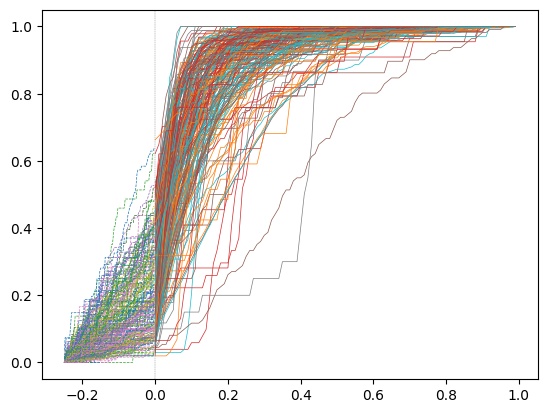

In [2]:
RE_PARTS = re.compile(r'-(\d+)-(\d)-best')
BASE_PATH = Path('../data/rankings')
RESOLUTION = 100
RECALL_TARGET = 0.99

# after how many documents recall target was reached
target_reached = []
target_reached_prio = [] # relative to prioritised portion only
# size of datasets
dataset_len = []
# number of random init
num_init = []
# number of includes in random init
num_init_incl = []

fig, ax = plt.subplots()

x_rand = np.arange(RESOLUTION) / RESOLUTION
x_prio = np.arange(RESOLUTION) / RESOLUTION

curves_rand = []
curves_prio = []
raw_curves_rand = []
raw_curves_prio = []

for file in BASE_PATH.glob('*.json'):
    key = RE_PARTS.sub('', file.stem)
    parts = RE_PARTS.findall(file.stem)[0]
    data_file = str(file).replace('.json', '.feather')
    df = pd.read_feather(data_file).sort_values('order')

    n_docs = df.shape[0]
    n_incl = df['label'].sum()
    n_rand = (df['random']==True).sum()
    n_rand_incl = df[df['random']==True]['label'].sum()

    raw_curve_rand = df[df['random'] == True]['label'].cumsum()
    raw_x_rand = (np.arange(len(raw_curve_rand)) / len(raw_curve_rand))
    curve_rand = np.array([raw_curve_rand[raw_x_rand >= th].min() for th in x_rand])

    raw_curve_prio = df[df['random'] == False]['label'].cumsum() + n_rand_incl
    raw_x_prio = (np.arange(len(raw_curve_prio)) / len(raw_curve_prio))
    curve_prio = np.array([raw_curve_prio[raw_x_prio >= th].min() for th in x_prio])

    target_reached.append((np.argwhere(((raw_curve_prio)/n_incl) > RECALL_TARGET).min() + n_rand)/n_docs)
    target_reached_prio.append((np.argwhere(((raw_curve_prio)/n_incl) > RECALL_TARGET).min())/len(raw_curve_prio))

    ax.plot((x_rand - 1) / 4, curve_rand / n_incl, lw=0.5, ls='--')
    ax.plot(x_prio, curve_prio / n_incl, lw=0.5)

    curves_rand.append(curve_rand)
    curves_prio.append(curve_prio)
    raw_curves_rand.append(raw_curve_rand)
    raw_curves_prio.append(raw_curve_prio)

# plot vertical line for where random sample ends
ax.axvline(0, ls='--', c='grey', lw=0.3)
curves_rand = np.array(curves_rand)
curves_prio = np.array(curves_prio)

x_rand = (x_rand - 1)/4

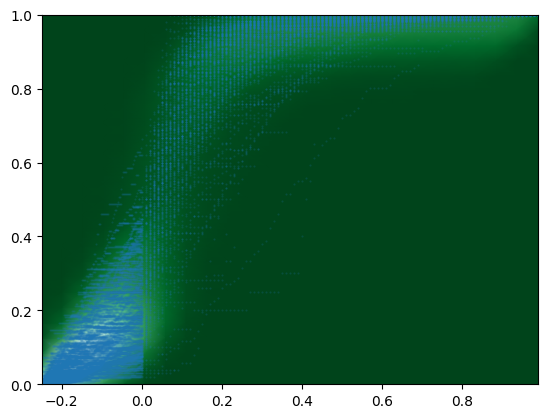

In [3]:
fig, ax = plt.subplots()

n_incl = curves_prio.max(axis=1)
prop_rand = (curves_rand.T / n_incl).T
prop_prio = (curves_prio.T / n_incl).T

scatter_y = np.concat([prop_rand.reshape((-1,)), prop_prio.reshape((-1,))])
scatter_x = np.concat([np.tile(x_rand, prop_rand.shape[0]), np.tile(x_prio, prop_prio.shape[0])])

nbins=25
k = gaussian_kde((scatter_x, scatter_y))
xi, yi = np.mgrid[scatter_x.min():scatter_x.max():nbins*1j, scatter_y.min():scatter_y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
#ax.contour(xi, yi, zi.reshape(xi.shape) )
plt.scatter(scatter_x, scatter_y, s=0.3, alpha=0.2)

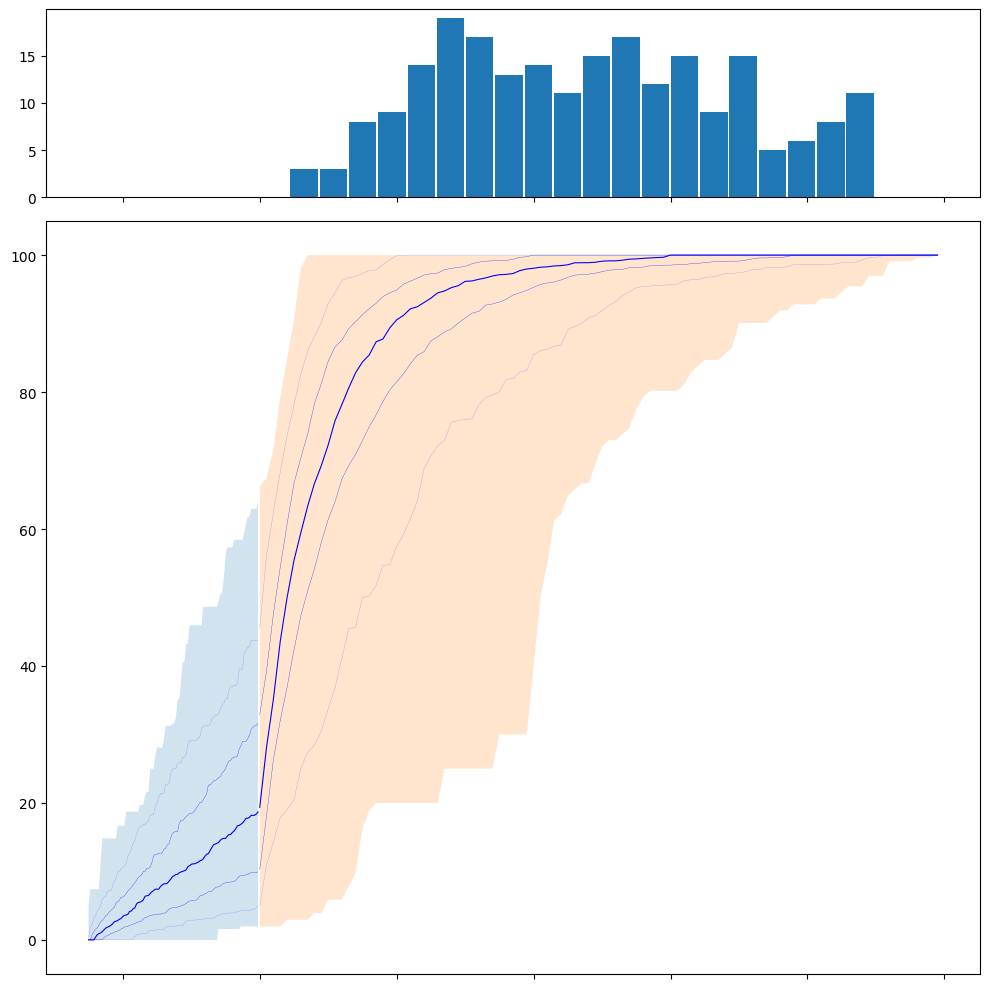

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [1, 4]}, figsize=(10,10))

n_incl = curves_prio.max(axis=1)
prop_rand = (curves_rand.T / n_incl).T
prop_prio = (curves_prio.T / n_incl).T

def draw(x, y):
    ax.plot(x, np.percentile(y, 95, axis=0), c='blue', lw=0.2, alpha=0.4)
    ax.plot(x, np.percentile(y, 75, axis=0), c='blue', lw=0.2)
    ax.plot(x, np.percentile(y, 50, axis=0), c='blue', lw=0.8)
    ax.plot(x, np.percentile(y, 25, axis=0), c='blue', lw=0.2)
    ax.plot(x, np.percentile(y, 5, axis=0), c='blue', lw=0.2, alpha=0.4)
    ax.fill_between(x, y.min(axis=0), y.max(axis=0), alpha=0.2)

ax = axes[1]
draw(x_rand * 100, prop_rand * 100)
draw(x_prio * 100, prop_prio * 100)
ax.tick_params(labelbottom=False)
#ax.set_ylim(0,1)

ax = axes[0]
ax.tick_params(labeltop=False, labelbottom=False)
hy, hx = np.histogram(target_reached_prio, bins=20)
ax.bar(hx[:-1] * 100, hy, width=4)
fig.tight_layout()
#fig.savefig('../data/plots/curve_dist.pdf')

In [5]:
pd.Series(target_reached_prio).describe(percentiles=np.arange(0,1,0.05))

count    224.000000
mean       0.498322
std        0.212023
min        0.064896
0%         0.064896
5%         0.186022
10%        0.237831
15%        0.267660
20%        0.300020
25%        0.321175
30%        0.345613
35%        0.380826
40%        0.417940
45%        0.452542
50%        0.495009
55%        0.525169
60%        0.559336
65%        0.589239
70%        0.623171
75%        0.659761
80%        0.705844
85%        0.727151
90%        0.805955
95%        0.871948
max        0.919728
dtype: float64

# Full plots without adjustment

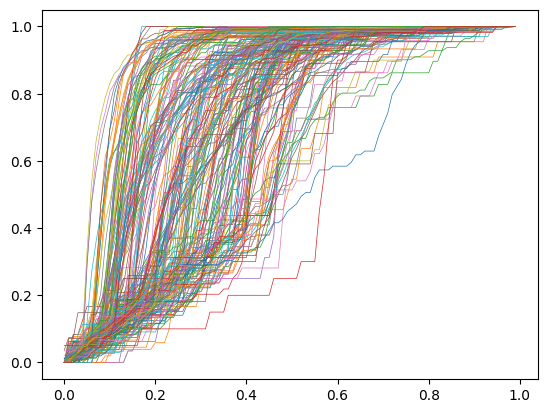

In [6]:
fig, ax = plt.subplots()

curves = []
raw_curves = []
target_reached = []
fractions = []

x = np.arange(RESOLUTION) / RESOLUTION
for file in BASE_PATH.glob('*.json'):
    key = RE_PARTS.sub('', file.stem)
    parts = RE_PARTS.findall(file.stem)[0]
    data_file = str(file).replace('.json', '.feather')
    df = pd.read_feather(data_file).sort_values('order')

    n_docs = df.shape[0]
    n_incl = df['label'].sum()
    
    raw_curve = df['label'].cumsum()
    raw_x = (np.arange(len(raw_curve)) / len(raw_curve))
    curve = np.array([raw_curve[raw_x >= th].min() for th in x])

    target_reached.append((np.argwhere((raw_curve / n_incl) > RECALL_TARGET).min()) / n_docs)
    fractions.append((df['random']==True).sum() / n_docs)

    curves.append(curve)
    raw_curves.append(raw_curve)

    ax.plot(x, curve / n_incl, lw=0.5)

curves = np.array(curves)
#fig.savefig('../data/plots/curves.pdf')

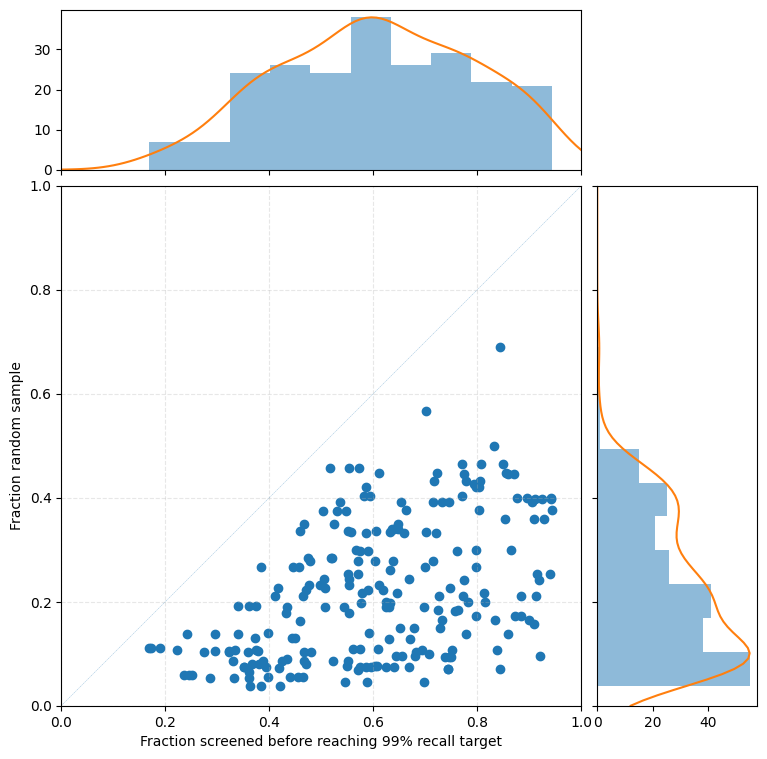

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

y = fractions
x = target_reached

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
axScatter.scatter(x, y)
axScatter.grid(ls='--', alpha=0.3)
axScatter.plot([0,1],[0,1], ls='--', alpha=0.5, lw=0.3)

xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])

axScatter.set_xlim((0, 1))
axScatter.set_ylim((0, 1))

xplt = np.linspace(0, 1, 100)

gy = gaussian_kde(x)(xplt)
hy, hx, _ = axHistx.hist(x, bins=10, alpha=0.5)
axHistx.plot(xplt, (gy / gy.max()) * hy.max())

gy = gaussian_kde(y)(xplt)
hy, hx, _ = axHisty.hist(y, bins=10, orientation='horizontal', alpha=0.5)
axHisty.plot((gy / gy.max()) * hy.max(), xplt)

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

axScatter.set_ylabel('Fraction random sample')
axScatter.set_xlabel(f'Fraction screened before reaching {RECALL_TARGET:.0%} recall target')

plt.show()

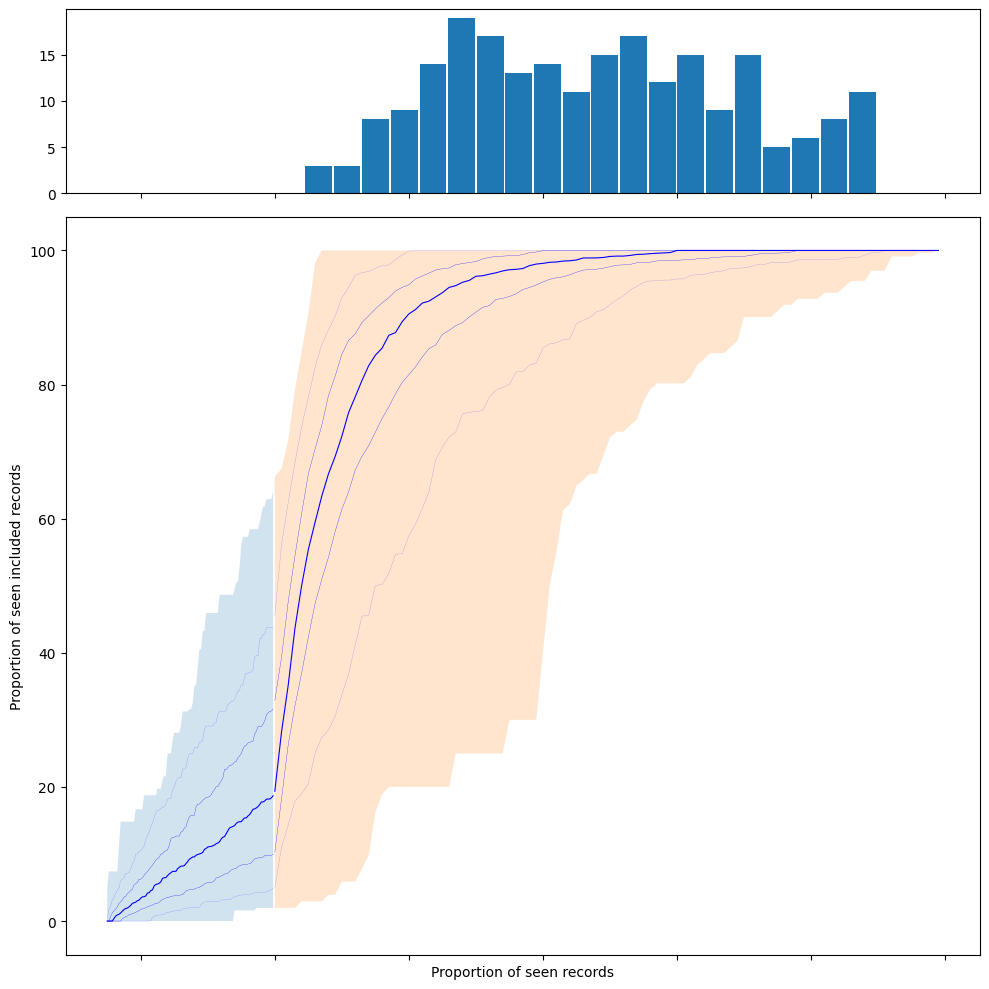

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [1, 4]}, figsize=(10,10))

n_incl = curves_prio.max(axis=1)
prop_rand = (curves_rand.T / n_incl).T
prop_prio = (curves_prio.T / n_incl).T

def draw(x, y):
    ax.plot(x, np.percentile(y, 95, axis=0), c='blue', lw=0.2, alpha=0.4)
    ax.plot(x, np.percentile(y, 75, axis=0), c='blue', lw=0.2)
    ax.plot(x, np.percentile(y, 50, axis=0), c='blue', lw=0.8)
    ax.plot(x, np.percentile(y, 25, axis=0), c='blue', lw=0.2)
    ax.plot(x, np.percentile(y, 5, axis=0), c='blue', lw=0.2, alpha=0.4)
    ax.fill_between(x, y.min(axis=0), y.max(axis=0), alpha=0.2)

ax = axes[1]
draw(x_rand * 100, prop_rand * 100)
draw(x_prio * 100, prop_prio * 100)
ax.tick_params(labelbottom=False)
#ax.set_ylim(0,1)

ax.set_ylabel('Proportion of seen included records')
ax.set_xlabel('Proportion of seen records')

ax = axes[0]
ax.tick_params(labeltop=False, labelbottom=False)
hy, hx = np.histogram(target_reached_prio, bins=20)
ax.bar(hx[:-1] * 100, hy, width=4)

fig.tight_layout()
fig.savefig('../data/plots/curve_dist.pdf')


In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [1, 4]}, figsize=(10,10))

n_incl = curves.max(axis=1)
prop = (curves.T / n_incl).T

ax = axes[1]
ax.plot(x, np.percentile(prop, 95, axis=0), c='blue', lw=0.2, alpha=0.4)
ax.plot(x, np.percentile(prop, 75, axis=0), c='blue', lw=0.2)
ax.plot(x, np.percentile(prop, 50, axis=0), c='blue', lw=0.8)
ax.plot(x, np.percentile(prop, 25, axis=0), c='blue', lw=0.2)
ax.plot(x, np.percentile(prop, 5, axis=0), c='blue', lw=0.2, alpha=0.4)
ax.fill_between(x, prop.min(axis=0), prop.max(axis=0), alpha=0.2)
ax.tick_params(labelbottom=True)
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
ax.grid()

ax = axes[0]
ax.tick_params(labeltop=False, labelbottom=False)
hy, hx = np.histogram(target_reached, bins=20)
ax.bar(hx[:-1], hy, width=0.0375)

fig.tight_layout()